In [ ]:
!git clone https://github.com/CGC-UMCES/WORKSHOP-CGC-SCIPE-AI-ML-2025.git


In [ ]:
import os

# 👇 Student: Please change the below line to the full path to the "ML_Tutorial_Predict_Bottom_DO_from_Surface_Variables" folder
wd = "/content/WORKSHOP-CGC-SCIPE-AI-ML-2025/Day2-ML/ML_Tutorial_Predict_Bottom_DO_from_Surface_Variables"

if 'wd' in locals() and wd.strip() != "":
    os.chdir(wd)
    print("✅ Current working directory set to:", os.getcwd())
else:
    print("⚠️ Please set 'wd' to your folder path above before running this cell.")



# Tutorial 1. Predicting Bottom Dissolved Oxygen from Surface Variables

For this student workshop, we’ll skip the data preparation steps—but keep in mind that preparation is a critical part of any data science workflow. Section 1.2 contains the full data preparation process if you’d like to review it on your own, but we won’t walk through it here.

Starting from Section 1.3, you’ll work with the clean data that has already been prepared, and move straight into building machine learning models—beginning with Random Forest (and optionally MLP)—to predict bottom DO.


## 1.1 Introduction

This tutorial demonstrates how to predict bottom DO concentrations using surface-level water quality parameters from CBP Datahub such as:
- Chlorophyll-a
- Salinity
- Nutrients (e.g., TN, TP)
- Water temperature (WTEMP)

The raw data used in this tutorial can be downloaded from the Chesapeake Bay Program's Water Quality DataHub:  
🔗 https://datahub.chesapeakebay.net/WaterQuality

We downloaded data from **three mainstem stations** located in the upper, middle, and lower Chesapeake Bay, covering the period from **1984 to 2024**:

- **Upper Bay**: CB3.2  
- **Middle Bay**: CB5.1  
- **Lower Bay**: CB6.4  

The raw data files were saved in the folder: `CBP_RawData/`

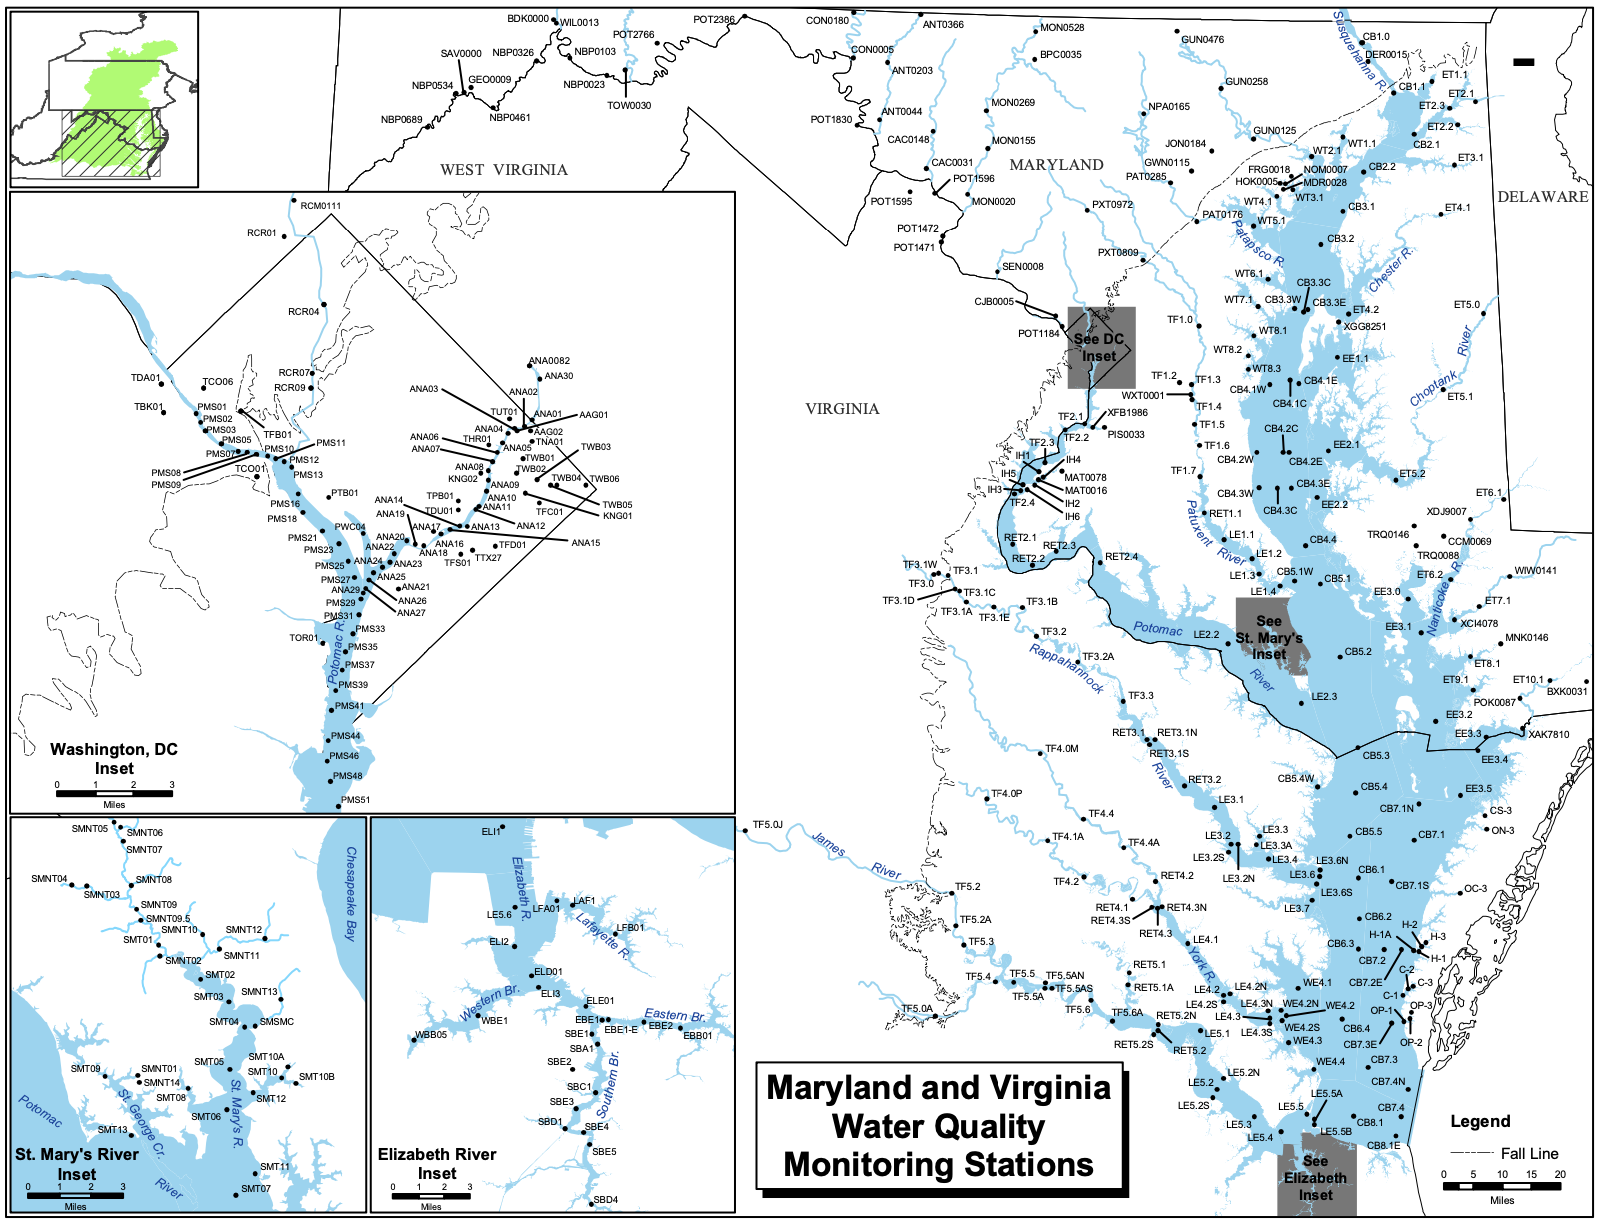

In [3]:
from IPython.display import Image
Image("map_of_mainstem_and_tributary_monitoring_stations.png")

## 1.2 Data Preparation

### 1.2.1 Raw Data Check

Before diving into data cleaning and modeling, we start by visually inspecting a sample from the raw data. This helps us confirm that:

- If multiple water quality parameters are measured on the same day
- Each parameter is recorded at different depths within the water column

This initial check ensures that we understand the data structure and can align surface and bottom values accurately in later steps.


In [120]:
import pandas as pd
import numpy as np

RAW_PATH = "CBP_RawData/Lower_StationCB6.4.csv"
df = pd.read_csv(RAW_PATH)

print("📋 Columns:", df.columns.tolist())
print(f"📊 Total rows: {len(df)}")

# Quick look at dates/parameters
_dates = pd.to_datetime(df.get('SampleDate'), errors='coerce')
print(f"📆 Date range: {_dates.min().date()} → {_dates.max().date()}")
print(f"📅 Unique sampling dates: {_dates.nunique()}")

_params = df.get('Parameter').astype(str).str.strip().unique()
print(f"🧪 Parameters measured ({len(_params)}): {_params}")

# Peek at one random day
sample_dates = _dates.dropna().unique()
if sample_dates.size:
    pick = np.random.choice(sample_dates)
    print(f"\n📅 Example day: {pick}")
    display(df[pd.to_datetime(df['SampleDate'], errors='coerce') == pick])


📋 Columns: ['MonitoringStation', 'EventId', 'Cruise', 'Program', 'Project', 'Agency', 'Source', 'Station', 'SampleDate', 'SampleTime', 'TotalDepth', 'UpperPycnocline', 'LowerPycnocline', 'Depth', 'Layer', 'SampleType', 'SampleReplicateType', 'Parameter', 'Qualifier', 'MeasureValue', 'Unit', 'Method', 'Lab', 'Problem', 'PrecisionPC', 'BiasPC', 'Details', 'Latitude', 'Longitude', 'TierLevel']
📊 Total rows: 23115
📆 Date range: 1984-07-14 → 2024-12-09
📅 Unique sampling dates: 618
🧪 Parameters measured (7): ['CHLA' 'DO' 'SALINITY' 'TN' 'TP' 'WTEMP' 'nan']

📅 Example day: 2014-06-24T00:00:00.000000000


,MonitoringStation,EventId,Cruise,Program,Project,Agency,Source,Station,SampleDate,SampleTime,TotalDepth,UpperPycnocline,LowerPycnocline,Depth,Layer,SampleType,SampleReplicateType,Parameter,Qualifier,MeasureValue,Unit,Method,Lab,Problem,PrecisionPC,BiasPC,Details,Latitude,Longitude,TierLevel
4974,CB6.4,394051.0,BAY627,TWQM,MAIN,VADEQ,ODU,CB6.4,6/24/2014,16:04:00,9.0,NaN,NaN,1.0,S,ISM,M1,DO,NaN,9.71,MG/L,F04,NaN,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3
4975,CB6.4,394051.0,BAY627,TWQM,MAIN,VADEQ,ODU,CB6.4,6/24/2014,16:04:00,9.0,NaN,NaN,5.0,M,ISM,M1,DO,NaN,6.82,MG/L,F04,NaN,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3
4976,CB6.4,394051.0,BAY627,TWQM,MAIN,VADEQ,ODU,CB6.4,6/24/2014,16:04:00,9.0,NaN,NaN,7.0,M,ISM,M1,DO,NaN,4.71,MG/L,F04,NaN,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3
4993,CB6.4,394051.0,BAY627,TWQM,MAIN,VADEQ,ODU,CB6.4,6/24/2014,16:04:00,9.0,NaN,NaN,3.0,AP,ISM,M1,DO,NaN,8.64,MG/L,F04,NaN,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3
4994,CB6.4,394051.0,BAY627,TWQM,MAIN,VADEQ,ODU,CB6.4,6/24/2014,16:04:00,9.0,NaN,NaN,8.0,B,ISM,M1,DO,NaN,4.04,MG/L,F04,NaN,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3
4995,CB6.4,394051.0,BAY627,TWQM,MAIN,VADEQ,ODU,CB6.4,6/24/2014,16:04:00,9.0,NaN,NaN,6.0,BP,ISM,M1,DO,NaN,6.10,MG/L,F04,NaN,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3
4996,CB6.4,394051.0,BAY627,TWQM,MAIN,VADEQ,ODU,CB6.4,6/24/2014,16:04:00,9.0,NaN,NaN,2.0,M,ISM,M1,DO,NaN,9.45,MG/L,F04,NaN,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3
4997,CB6.4,394051.0,BAY627,TWQM,MAIN,VADEQ,ODU,CB6.4,6/24/2014,16:04:00,9.0,NaN,NaN,4.0,M,ISM,M1,DO,NaN,7.96,MG/L,F04,NaN,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3
9987,CB6.4,394051.0,BAY627,TWQM,MAIN,VADEQ,ODU,CB6.4,6/24/2014,16:04:00,9.0,NaN,NaN,4.0,M,ISM,M1,SALINITY,NaN,20.24,PPT,F04,NaN,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3
9988,CB6.4,394051.0,BAY627,TWQM,MAIN,VADEQ,ODU,CB6.4,6/24/2014,16:04:00,9.0,NaN,NaN,2.0,M,ISM,M1,SALINITY,NaN,17.94,PPT,F04,NaN,NaN,NaN,NaN,NaN,37.23653,-76.20799,T3


### 1.2.2 Layer Selection

To prepare the dataset for modeling, we extract measurements for specific layers:

- **Surface layer values** for: CHLA, SALINITY, TN, TP, and WTEMP  
- **Bottom layer values** for: Dissolved Oxygen (DO)

Key steps include:

- Filtering the raw data to retain only the **surface** and **bottom** layers

After this step, each row in the dataset contains all the input features from the surface and the target value (DO) from the bottom.


In [123]:
# Normalize once
df['SampleDate']   = pd.to_datetime(df['SampleDate'], errors='coerce')
df['Parameter']    = df['Parameter'].astype(str).str.strip()
df['Layer']        = df['Layer'].astype(str).str.strip()
df['MeasureValue'] = pd.to_numeric(df['MeasureValue'], errors='coerce')

# Drop invalid rows
df = df.dropna(subset=['SampleDate', 'MeasureValue'])

# Define required params by layer
S_PARAMS = ['CHLA', 'SALINITY', 'TN', 'TP', 'WTEMP']  # surface
B_PARAMS = ['DO']                                     # bottom
REQUIRED = S_PARAMS + B_PARAMS

# Expected layer mapping
expected_layer = {**{p: 'S' for p in S_PARAMS}, **{p: 'B' for p in B_PARAMS}}

# Keep only required params at correct layers
df = df[df['Parameter'].isin(REQUIRED)]
df = df[df['Layer'] == df['Parameter'].map(expected_layer)]



### 1.2.3 Dataset Construction

Different parameters are not always measured on exactly the same dates. To create a usable dataset for modeling, we perform the following:

- Keep only the dates where **all required parameters** are available
- Ensure each final record includes:
  - Surface CHLA, SALINITY, TN, TP, WTEMP
  - Bottom-layer DO on the **same date**

This process results in a clean and aligned dataset suitable for training machine learning models.

In [126]:
# Choose duplicate policy for measurements within (date, parameter)
DUP_POLICY = 'mean'  # alternatives: 'first', 'median'

# Build wide matrix (1 row per date; columns are REQUIRED params)
# Keep order stable with reindex; sort chronologically
df_cleaned = (
    df.pivot_table(index='SampleDate',
                   columns='Parameter',
                   values='MeasureValue',
                   aggfunc=DUP_POLICY)
      .reindex(columns=REQUIRED)
      .sort_index()
)

print("✅ Constructed matrix shape (before completeness filter):", df_cleaned.shape)



✅ Constructed matrix shape (before completeness filter): (618, 6)


### 1.2.4 Validate Layer Assignments

We ensure that each parameter is observed at its correct layer:
- Surface parameters (CHLA, SALINITY, TN, TP, WTEMP) should come from layer `S`
- DO should come from layer `B`

Only dates with all six parameters at their expected layers are kept.


In [37]:
# At this point, the layer rule has already been enforced in Section 1.2.2.
# Here we ensure only dates with ALL required params remain.

missing_by_date = df_cleaned[REQUIRED].isna().sum(axis=1)
complete_mask = missing_by_date.eq(0)
print(f"✅ Complete dates (all {len(REQUIRED)} params): {complete_mask.sum()}")

# Keep only complete dates
df_cleaned = df_cleaned[complete_mask]


✅ Complete dates (all 6 params): 515


### 1.2.5 Reshape and Save Cleaned Dataset

We pivot to wide format (1 row per date), sort chronologically, and merge in the station name for reference.


In [40]:
import os

# Attach station (first seen per date), then save
station_by_date = (
    df[['SampleDate', 'Station']]
      .drop_duplicates(subset='SampleDate')
      .set_index('SampleDate')['Station']
)

df_cleaned = df_cleaned.merge(station_by_date, left_index=True, right_index=True)

os.makedirs("CBP_CleanedData", exist_ok=True)
station_name = str(df_cleaned['Station'].iloc[0]).replace(" ", "_")
out_path = f"CBP_CleanedData/final_cleaned_dataset_{station_name}.csv"

df_cleaned.to_csv(out_path)
print(f"✅ Saved: {out_path}")
print(f"Rows: {len(df_cleaned)}, Cols: {df_cleaned.shape[1]}")
display(df_cleaned.head(10))


✅ Saved: CBP_CleanedData/final_cleaned_dataset_CB6.4.csv
Rows: 515, Cols: 7


,CHLA,SALINITY,TN,TP,WTEMP,DO,Station
SampleDate,,,,,,,
1984-07-23,11.07,18.80,0.6153,0.031,24.7,12.5,CB6.4
1984-08-07,10.56,14.50,0.4275,0.042,27.7,2.5,CB6.4
1984-08-27,11.86,17.40,0.6275,0.058,27.2,3.9,CB6.4
1984-09-10,14.90,19.20,0.4103,0.050,23.9,4.0,CB6.4
1984-09-24,11.81,20.30,0.4675,0.035,22.8,4.7,CB6.4
1984-10-08,17.74,19.80,0.5175,0.040,18.2,8.1,CB6.4
1984-10-22,14.02,20.60,0.3275,0.029,17.4,5.2,CB6.4
1984-11-16,5.00,20.28,0.4790,0.036,12.5,9.1,CB6.4
1984-12-11,4.39,21.82,0.3846,0.019,7.5,9.4,CB6.4


## 1.3 Random Forest Model

This section compares two machine learning models for predicting bottom-layer dissolved oxygen (DO) from surface-level water quality parameters:
- 🌲 **Random Forest Regressor**
- 🧠 **Multi-Layer Perceptron (MLP)**

You can start from here with the cleaned dataset (`final_cleaned_dataset_{station id}.csv`) if you want skip the preprocessing steps. 

Choose your station:

Upper Bay: CB3.2

Middle Bay: CB5.1

Lower Bay: CB6.4

### 1.3.1 Load Cleaned Dataset

Select which station's dataset you want to load by modifying the `filename` below. Each file was saved earlier with a station-specific name.


In [129]:
import pandas as pd

# === Choose which station's dataset to load ===
filename = "CBP_CleanedData/final_cleaned_dataset_CB3.2.csv"  # 👈 change as needed (e.g., CB3.2, CB6.4)

# Load the cleaned dataset (expects columns: CHLA, SALINITY, TN, TP, WTEMP, DO, Station)
df_cleaned = pd.read_csv(filename, parse_dates=["SampleDate"])
df_cleaned = df_cleaned.set_index("SampleDate").sort_index()

# Quick peek
display(df_cleaned.head())
print("Columns:", list(df_cleaned.columns))



,CHLA,SALINITY,TN,TP,WTEMP,DO,Station
SampleDate,,,,,,,
1984-07-12,2.7,1.01,1.478,0.063,24.5,4.4,CB3.2
1984-07-25,5.3,0.79,1.625,0.070,26.0,1.3,CB3.2
1984-08-07,17.4,3.06,1.212,0.044,26.2,0.0,CB3.2
1984-08-30,6.0,6.87,1.039,0.041,25.3,2.6,CB3.2
1984-09-12,7.3,7.87,0.669,0.031,23.1,2.7,CB3.2


Columns: ['CHLA', 'SALINITY', 'TN', 'TP', 'WTEMP', 'DO', 'Station']


### 1.3.2 Select Features & Target
Predict bottom-layer DO using surface features: CHLA, SALINITY, TN, TP, WTEMP.

In [132]:
import numpy as np

FEATURES = ["CHLA", "SALINITY", "TN", "TP", "WTEMP"]
TARGET   = "DO"

# Use only columns that exist (robust to missing ones)
features = [c for c in FEATURES if c in df_cleaned.columns]
assert TARGET in df_cleaned.columns, f"Target '{TARGET}' not found in df_cleaned."

X = df_cleaned[features].copy()
y = df_cleaned[TARGET].copy()

# Drop rows with any missing feature/target
mask = X.notna().all(axis=1) & y.notna()
X, y = X[mask], y[mask]
print(f"Using features: {features}")
print("Shapes:", X.shape, y.shape)


Using features: ['CHLA', 'SALINITY', 'TN', 'TP', 'WTEMP']
Shapes: (617, 5) (617,)


### 1.3.2 Train/Test Split

We split the dataset into training and testing sets using 80/20 ratio. The features include 5 surface variables, and the target is bottom-layer DO.


In [135]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
X_train.shape, X_test.shape

((493, 5), (124, 5))

### 1.3.3 Train Random Forest Model

We fit a Random Forest Regressor using the training data and evaluate its performance on the test set using RMSE and R².


In [138]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"RF — MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")


RF — MAE: 1.343, RMSE: 1.660, R²: 0.730


### 1.3.4 Visualize Predictions

We plot the predicted and true DO values to visually assess model performance.


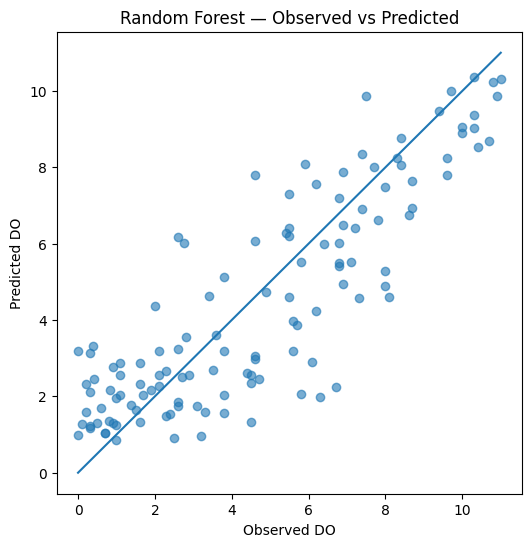

In [143]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Observed vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
lim_min = min(y_test.min(), y_pred.min())
lim_max = max(y_test.max(), y_pred.max())
plt.plot([lim_min, lim_max], [lim_min, lim_max])
plt.xlabel("Observed DO")
plt.ylabel("Predicted DO")
plt.title("Random Forest — Observed vs Predicted")
plt.show()


### 1.3.5 Visualize a Tree

We plot one of the decision trees from the Random Forest to see how it makes predictions using splits on input variables.


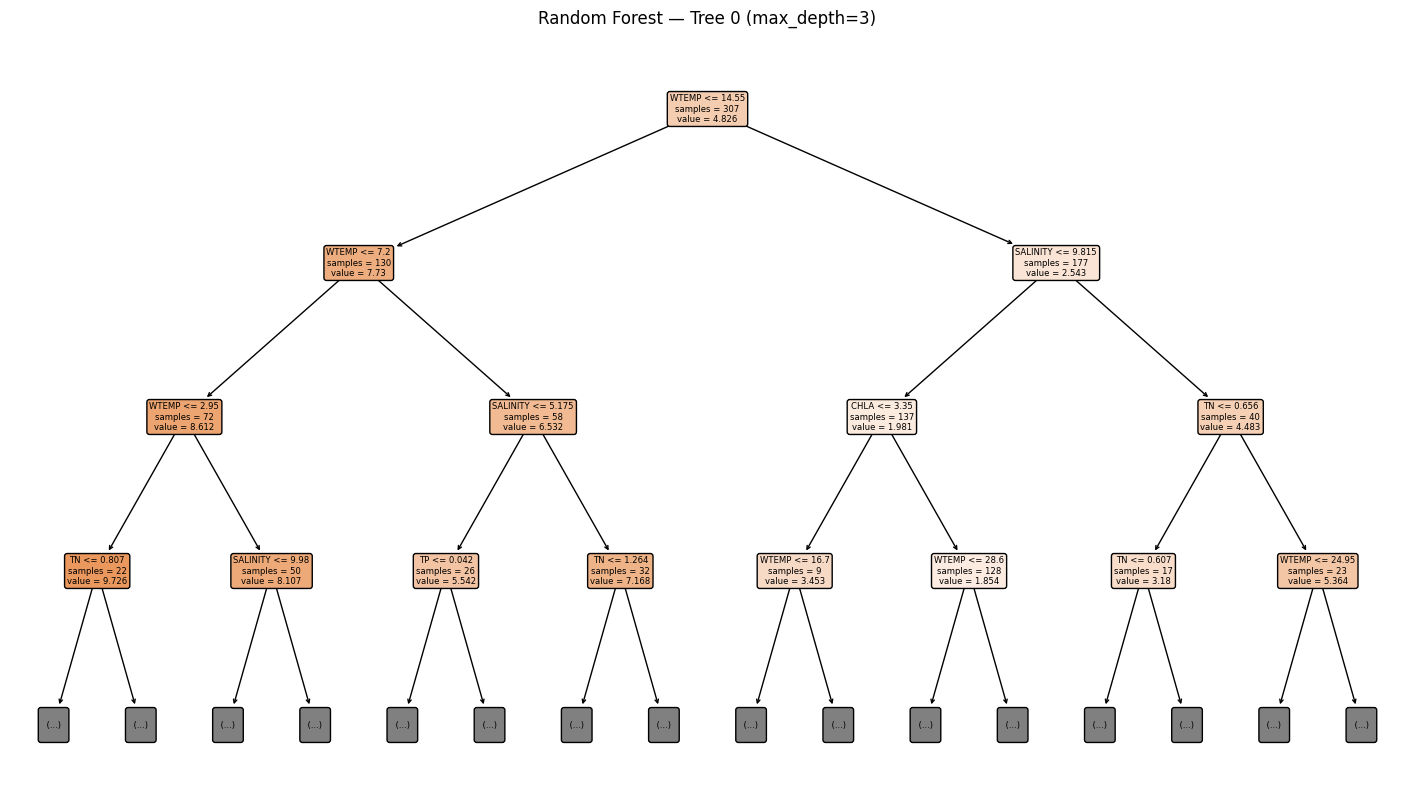

In [146]:
# Visualize a single tree from the trained Random Forest (rf)
# Assumes you already ran 1.3.2–1.3.4 and have `rf` and `features`.

from sklearn import tree
import matplotlib.pyplot as plt

# Pick a tree to visualize (0..len(rf.estimators_)-1)
TREE_INDEX = 0
est = rf.estimators_[TREE_INDEX]

# Limit depth for readability in a workshop
MAX_DEPTH_TO_SHOW = 3

plt.figure(figsize=(18, 10))
tree.plot_tree(
    est,
    feature_names=features,
    filled=True,
    rounded=True,
    impurity=False,
    max_depth=MAX_DEPTH_TO_SHOW
)
plt.title(f"Random Forest — Tree {TREE_INDEX} (max_depth={MAX_DEPTH_TO_SHOW})")
plt.show()



### 1.3.6 SHAP Interpretation

We use SHAP (SHapley Additive exPlanations) to interpret how each feature contributes to the Random Forest predictions.


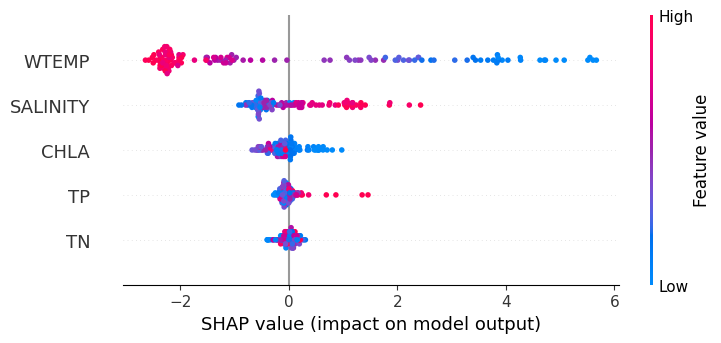

In [149]:
import shap
# Create explainer for RandomForest
explainer = shap.Explainer(rf, X_train,feature_names=features)

# Compute SHAP values with additivity check disabled
shap_values = explainer(X_test, check_additivity=False)
shap.plots.beeswarm(shap_values)

#### SHAP Dependence Plots with LOWESS Fits

To dig deeper, we can plot each feature’s values against its SHAP contributions, adding a smooth LOWESS trend line. This shows whether increasing a feature tends to push DO predictions up or down.

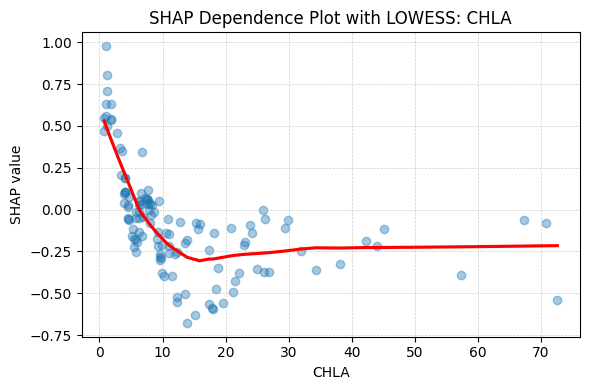

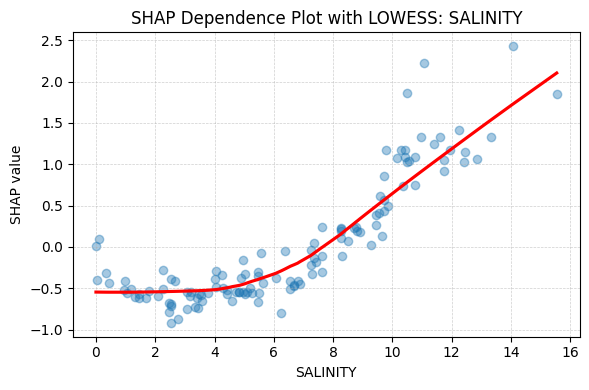

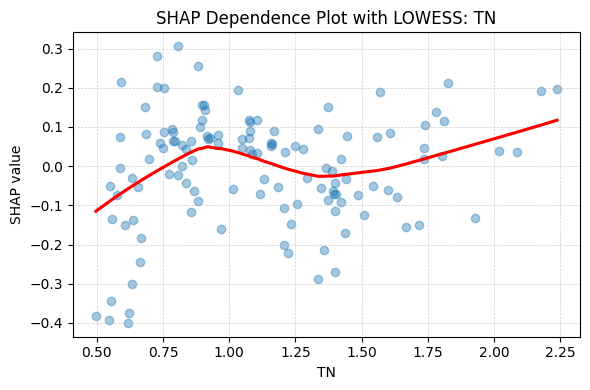

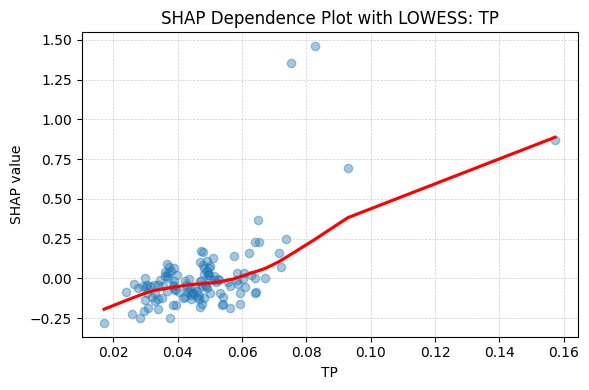

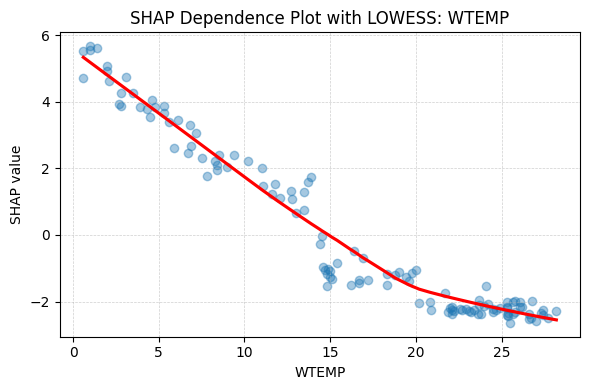

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure X_test is a DataFrame
if isinstance(X_test, np.ndarray):
    X_test_df = pd.DataFrame(X_test, columns=features)
else:
    X_test_df = X_test[features].copy()

# SHAP values as array (n_samples, n_features)
shap_array = shap_values.values

# Plot dependence with LOWESS for each feature
for i, name in enumerate(features):
    plt.figure(figsize=(6, 4))
    sns.regplot(
        x=X_test_df[name],
        y=shap_array[:, i],
        lowess=True,
        scatter_kws={"alpha": 0.4},
        line_kws={"color": "red"}
    )
    plt.xlabel(name)
    plt.ylabel("SHAP value")
    plt.title(f"SHAP Dependence Plot with LOWESS: {name}")
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.show()


#### SHAP Bar Plot

This plot shows the average absolute contribution of each feature to model predictions.


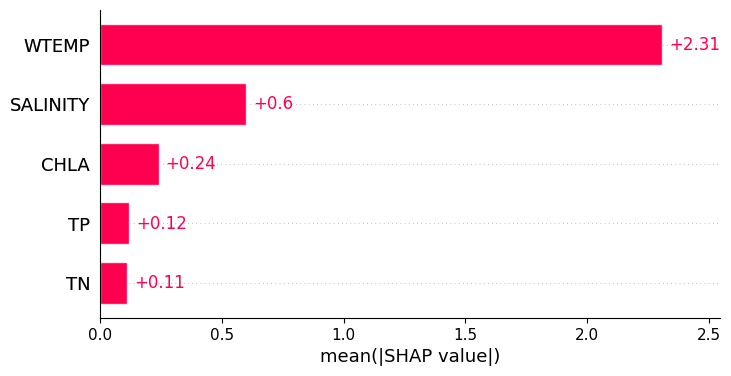

In [157]:
shap.plots.bar(shap_values)

### 1.3.7 Save the Trained Model
We save the trained Random Forest model (and optionally the features list) to a file, so it can be reloaded later without retraining.

In [160]:
import joblib
import os

# Ensure output folder exists
os.makedirs("SavedModels", exist_ok=True)

# Filepath for saving
model_path = "SavedModels/Predict_Bottom_DO_CB3dot2_RF.pkl"
joblib.dump({"model": rf, "features": features}, model_path)

print(f"✅ Random Forest model saved to {model_path}")


✅ Random Forest model saved to SavedModels/Predict_Bottom_DO_CB3dot2_RF.pkl


### 1.3.8 Bonus: Test RF on Another Station

Want to test the Random Forest model trained on one station’s data using a cleaned dataset from a **different** station?



📍 Testing Saved Model on New Station Data
RMSE (other station): 1.8711206830983933
R² (other station): 0.7551389106894792


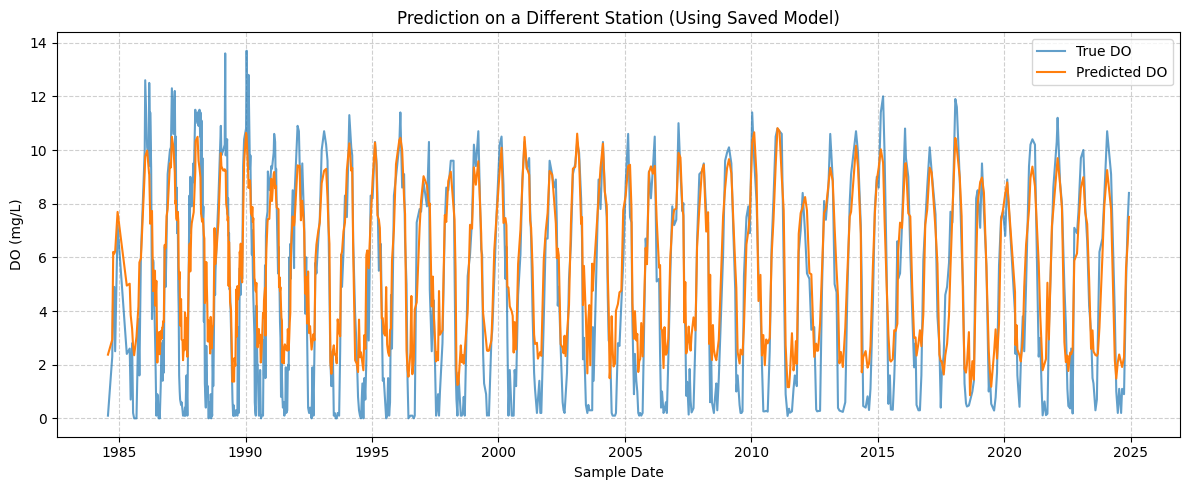

In [163]:
import joblib
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === Load the previously saved model ===
saved = joblib.load("SavedModels/Predict_Bottom_DO_CB3dot2_RF.pkl")
rf_loaded = saved["model"]
features_loaded = saved["features"]

# === Load external station dataset ===
test_station_file = "CBP_CleanedData/final_cleaned_dataset_CB5.1.csv"  # 👈 change this to test other stations
df_test_other = pd.read_csv(test_station_file, parse_dates=["SampleDate"], index_col="SampleDate")
df_test_other = df_test_other.sort_index()  # ensure chronological order

# === Extract features and target DO ===
X_other = df_test_other[features_loaded].dropna()
y_other = df_test_other.loc[X_other.index, "DO"]  # align target with available features

# === Predict using the loaded RF model ===
y_pred_other = rf_loaded.predict(X_other)

# === Evaluate ===
print("\n📍 Testing Saved Model on New Station Data")
print("RMSE (other station):", mean_squared_error(y_other, y_pred_other))
print("R² (other station):", r2_score(y_other, y_pred_other))

# === Plot with SampleDate on x-axis ===
plt.figure(figsize=(12, 5))
plt.plot(X_other.index, y_other, label="True DO", alpha=0.7)
plt.plot(X_other.index, y_pred_other, label="Predicted DO")
plt.legend()
plt.title("Prediction on a Different Station (Using Saved Model)")
plt.xlabel("Sample Date")
plt.ylabel("DO (mg/L)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



## 1.4 MLP Model

In this section, we build and train a simple neural network (MLP) to predict bottom DO using surface parameters. We’ll also visualize training loss and interpret results using SHAP values.


### 1.4.1 Load and Scale Data

Neural networks require scaled input features. We use `StandardScaler` to normalize the training and test data.


In [167]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Features and target (reusing df_cleaned from earlier)
FEATURES = ["CHLA", "SALINITY", "TN", "TP", "WTEMP"]
TARGET   = "DO"

features = [c for c in FEATURES if c in df_cleaned.columns]
assert TARGET in df_cleaned.columns, f"Missing target '{TARGET}' in df_cleaned."

# X, y (keep rows with non-missing values)
X = df_cleaned[features].copy()
y = df_cleaned[TARGET].copy()
mask = X.notna().all(axis=1) & y.notna()
X, y = X[mask], y[mask]

# Train/test split (keep indices to plot by date later)
RANDOM_STATE = 42
TEST_SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit on train
X_test_scaled  = scaler.transform(X_test)       # transform test

print("Features used:", features)
print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Features used: ['CHLA', 'SALINITY', 'TN', 'TP', 'WTEMP']
Shapes: (493, 5) (124, 5) (493,) (124,)


### 1.4.2 Build and Train the MLP

We define a 2-layer neural network and use early stopping to prevent overfitting. The model is trained using mean squared error (MSE) loss.


In [170]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(RANDOM_STATE)

mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # regression output
])

mlp_model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = mlp_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.0808 - val_loss: 25.0723
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 22.2917 - val_loss: 16.1973
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 13.5860 - val_loss: 8.2829
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 7.3233 - val_loss: 4.7195
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 5.1406 - val_loss: 3.4357
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 4.1650 - val_loss: 3.0110
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 3.6594 - val_loss: 2.8529
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 3.7206 - val_loss: 2.7273
Epoch 9/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 3.5522 - val_loss: 2.6809
Epoch 10/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 3.2857 - val_loss: 2.7036
Epoch 11/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 3.3041 - val_loss: 2.6130
Epoch 12/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/s

### 1.4.3 Plot Training vs Validation Loss

We plot the MSE loss for both training and validation over epochs to assess learning dynamics.


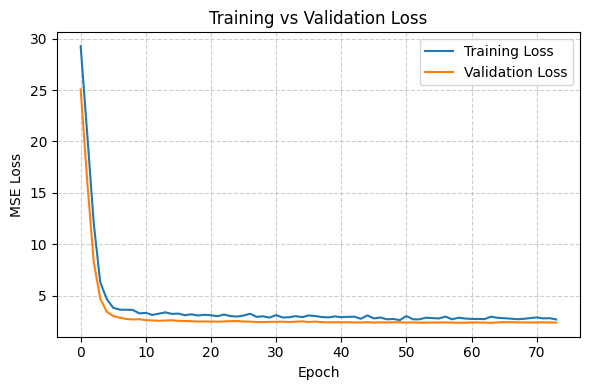

In [173]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 1.4.4 Predict and Evaluate MLP

We use the trained MLP model to predict on the test set and evaluate performance using RMSE and R².



🧠 MLP Model Results:
RMSE: 1.5084544106471598
R²: 0.7772841500766936


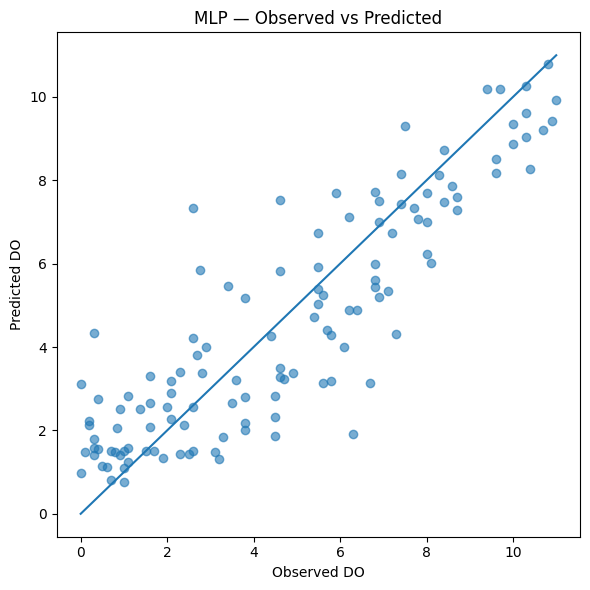

In [176]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Predict on test set
y_pred_mlp = mlp_model.predict(X_test_scaled, verbose=0).flatten()

print("\n🧠 MLP Model Results:")
print("RMSE:", mean_squared_error(y_test, y_pred_mlp))
print("R²:", r2_score(y_test, y_pred_mlp))

# Observed vs Predicted (no time axis)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_mlp, alpha=0.6)
lim_min = min(y_test.min(), y_pred_mlp.min())
lim_max = max(y_test.max(), y_pred_mlp.max())
plt.plot([lim_min, lim_max], [lim_min, lim_max])  # 1:1 line
plt.xlabel("Observed DO")
plt.ylabel("Predicted DO")
plt.title("MLP — Observed vs Predicted")
plt.tight_layout()
plt.show()


### 1.4.5 SHAP Interpretation

We use SHAP values to understand how each surface feature contributes to DO predictions made by the MLP model.


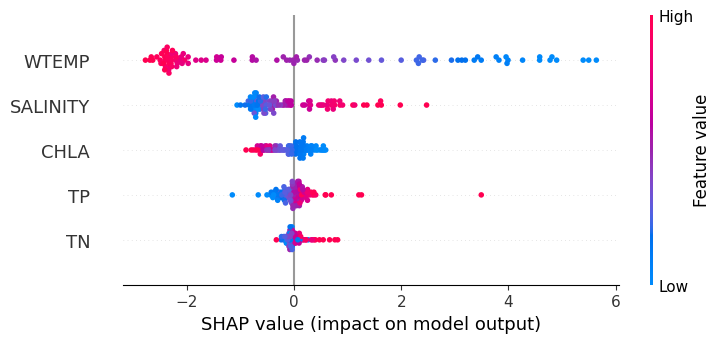

In [179]:
import shap

features = ['CHLA', 'SALINITY', 'TN', 'TP', 'WTEMP']

# Use the same representation the model sees (scaled inputs)
explainer = shap.Explainer(mlp_model, X_train_scaled, feature_names=features)

# Limit to first 100 test points for speed
N = min(100, X_test_scaled.shape[0])
shap_values = explainer(X_test_scaled[:N])   # <-- no check_additivity here

# Global summary (beeswarm)
shap.plots.beeswarm(shap_values)


#### shap dependence plot
Use unscaled feature values on x-axis and SHAP contributions on y-axis, sized to the same N rows.

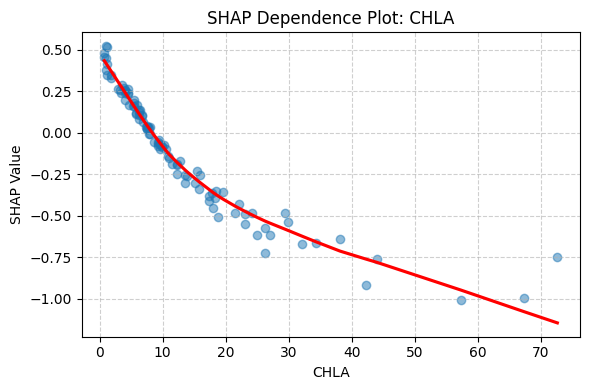

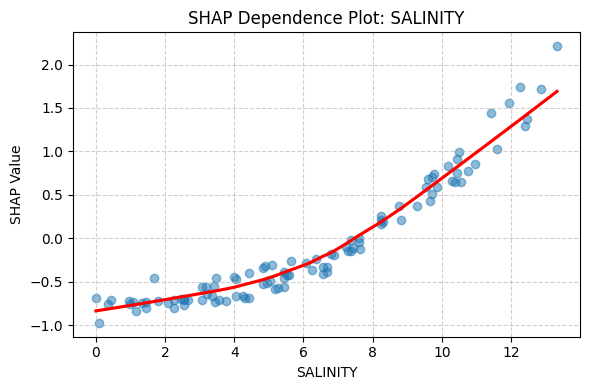

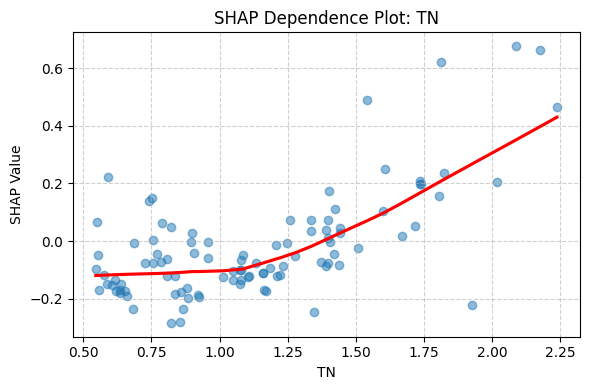

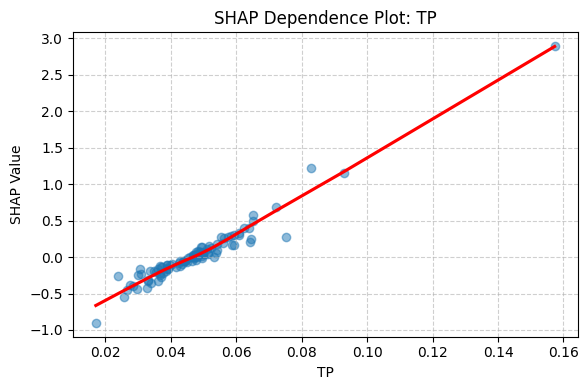

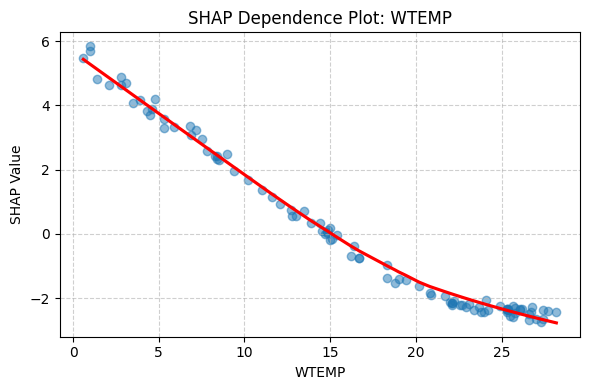

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure we use the same N rows as above
input_df = pd.DataFrame(X_test[:N], columns=features)  # unscaled inputs
shap_df   = pd.DataFrame(shap_values.values, columns=features)

for feat in features:
    plt.figure(figsize=(6,4))
    sns.regplot(
        x=input_df[feat],
        y=shap_df[feat],
        lowess=True,
        scatter_kws={'alpha': 0.5},
        line_kws={'color': 'red'}
    )
    plt.xlabel(feat)
    plt.ylabel("SHAP Value")
    plt.title(f"SHAP Dependence Plot: {feat}")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


### 1.4.6 Visualize MLP Architecture

This plot shows the structure of the MLP model including number of layers and connections.


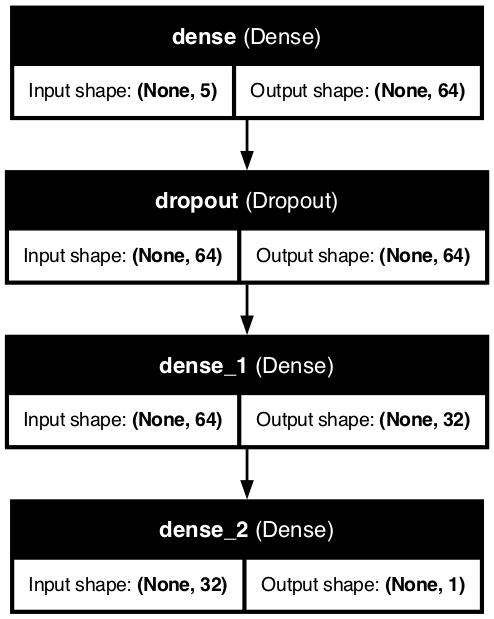

In [100]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import os

os.makedirs("SavedModels", exist_ok=True)

plot_path = "SavedModels/mlp_architecture.png"
try:
    plot_model(mlp_model, to_file=plot_path, show_shapes=True, show_layer_names=True, dpi=100)
    display(Image(plot_path))
except Exception as e:
    print("⚠️ Could not render model diagram (Graphviz/pydot may be missing):", e)



### 1.4.7 Save the MLP Model
Save the trained Keras model, the scaler, and the feature list so you can reload and predict later without retraining.

In [191]:
import joblib, os
os.makedirs("SavedModels", exist_ok=True)

# Save Keras model (TensorFlow SavedModel format)
mlp_model.save("SavedModels/Predict_Bottom_DO_CB3dot2_MLP.keras")

# Save the scaler and features used
joblib.dump({"scaler": scaler, "features": features}, "SavedModels/Predict_Bottom_DO_CB3dot2_MLP_meta.pkl")

print("✅ Saved:")
print("  - Model:   SavedModels/Predict_Bottom_DO_MLP.keras")
print("  - Meta:    SavedModels/Predict_Bottom_DO_MLP_meta.pkl (scaler + features)")


✅ Saved:
  - Model:   SavedModels/Predict_Bottom_DO_MLP.keras
  - Meta:    SavedModels/Predict_Bottom_DO_MLP_meta.pkl (scaler + features)


### 1.4.8 Bonus: Test MLP on Another Station

We evaluate how well the MLP model trained on one station performs on a dataset from a different location.



🧪 Cross-Station Evaluation (Saved MLP)
RMSE: 1.5654410672279082
R²:   0.7615555716155251


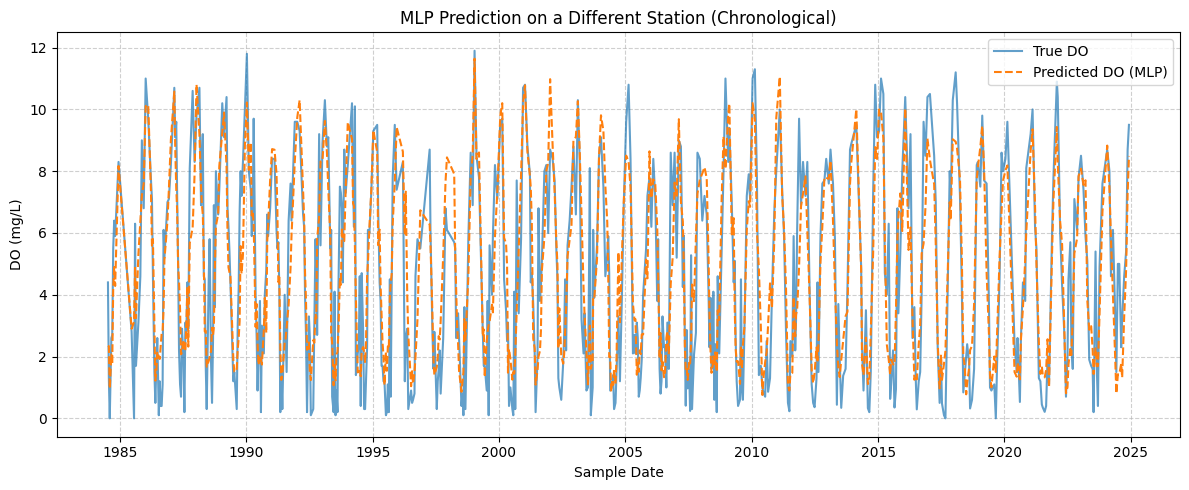

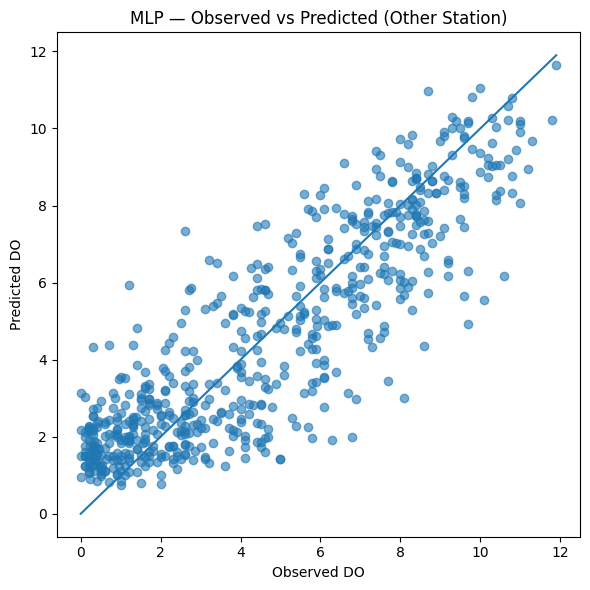

In [194]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, r2_score

# === Load saved MLP model + metadata (scaler, features) ===
mlp_model_path = "SavedModels/Predict_Bottom_DO_CB3dot2_MLP.keras"
mlp_meta_path  = "SavedModels/Predict_Bottom_DO_CB3dot2_MLP_meta.pkl"

assert os.path.exists(mlp_model_path),  "Saved MLP model not found."
assert os.path.exists(mlp_meta_path),   "Saved MLP metadata (scaler/features) not found."

mlp_loaded = load_model(mlp_model_path)
meta       = joblib.load(mlp_meta_path)
scaler     = meta["scaler"]
features   = meta["features"]

# === Load another station’s cleaned dataset ===
filename_other = "CBP_CleanedData/final_cleaned_dataset_CB3.2.csv"  # 👈 change as needed
df_other = pd.read_csv(filename_other, parse_dates=["SampleDate"], index_col="SampleDate").sort_index()

# === Prepare inputs: keep only rows with all required features ===
X_other = df_other[features].dropna()       # drop rows missing any feature the MLP expects
y_other = df_other.loc[X_other.index, "DO"] # align target to available rows

# === Scale inputs with the training scaler, then predict ===
X_other_scaled = scaler.transform(X_other)
y_other_pred   = mlp_loaded.predict(X_other_scaled, verbose=0).flatten()

# === Evaluate ===
rmse = mean_squared_error(y_other, y_other_pred)
r2   = r2_score(y_other, y_other_pred)
print("\n🧪 Cross-Station Evaluation (Saved MLP)")
print("RMSE:", rmse)
print("R²:  ", r2)

# === Plot 1: Time series (chronological) ===
plt.figure(figsize=(12,5))
plt.plot(y_other.index, y_other.values, label="True DO", alpha=0.7)
plt.plot(y_other.index, y_other_pred, label="Predicted DO (MLP)", linestyle="--")
plt.title("MLP Prediction on a Different Station (Chronological)")
plt.xlabel("Sample Date"); plt.ylabel("DO (mg/L)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# === Plot 2: Observed vs Predicted scatter (evaluation view) ===
plt.figure(figsize=(6,6))
plt.scatter(y_other, y_other_pred, alpha=0.6)
lim_min = min(y_other.min(), y_other_pred.min())
lim_max = max(y_other.max(), y_other_pred.max())
plt.plot([lim_min, lim_max], [lim_min, lim_max])  # 1:1 line
plt.xlabel("Observed DO")
plt.ylabel("Predicted DO")
plt.title("MLP — Observed vs Predicted (Other Station)")
plt.tight_layout()
plt.show()


## 1.5 Compare RF and MLP Predictions

This plot shows predictions from both models on the same test set. 


,MAE,RMSE,R2
RandomForest,1.343,1.660,0.730
MLP,1.215,1.508,0.777


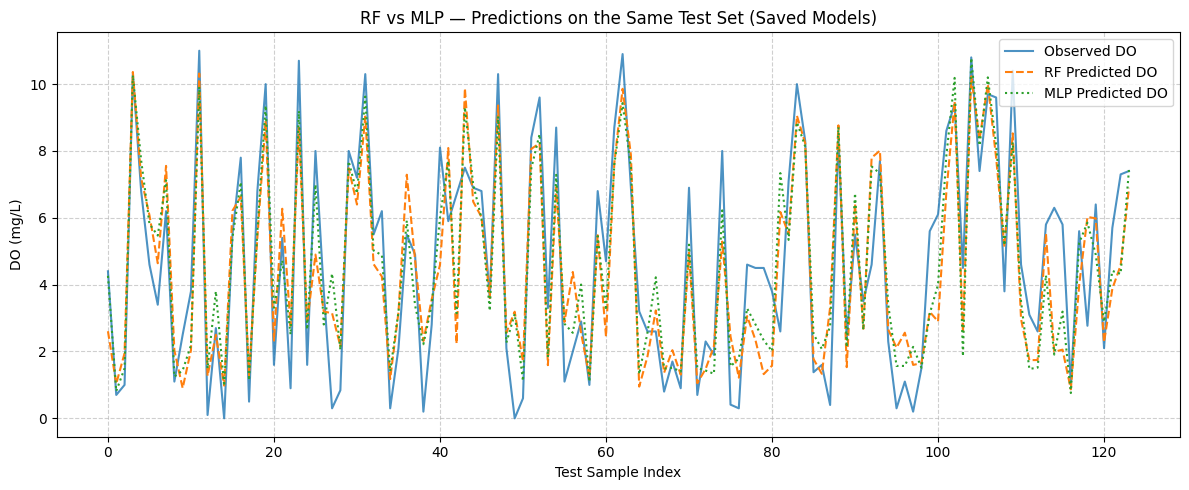

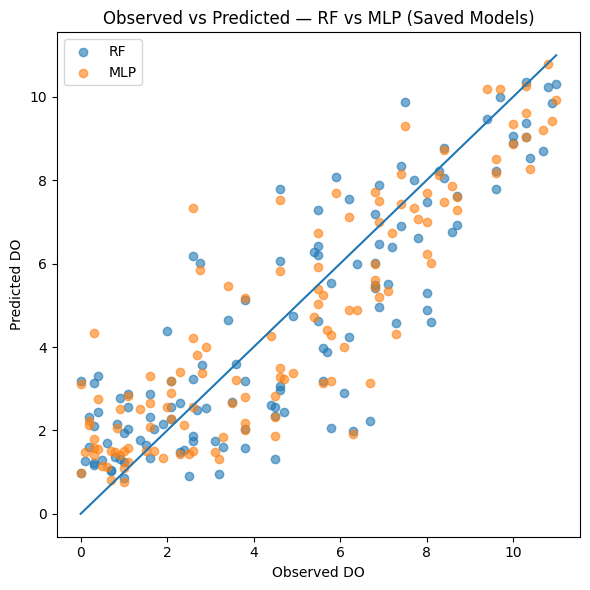

In [197]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# === Load Random Forest ===
rf_saved = joblib.load("SavedModels/Predict_Bottom_DO_CB3dot2_RF.pkl")
rf_model = rf_saved["model"]
rf_features = rf_saved["features"]

# === Load MLP + metadata (scaler + features) ===
mlp_model = load_model("SavedModels/Predict_Bottom_DO_CB3dot2_MLP.keras")
mlp_meta  = joblib.load("SavedModels/Predict_Bottom_DO_CB3dot2_MLP_meta.pkl")
scaler    = mlp_meta["scaler"]
mlp_features = mlp_meta["features"]

# --- Ensure consistent feature set ---
assert rf_features == mlp_features, "RF and MLP were trained with different features!"

features = rf_features  # both are the same

# === Prepare test split again (same as in 1.4.1) ===
from sklearn.model_selection import train_test_split

X = df_cleaned[features].dropna()
y = df_cleaned.loc[X.index, "DO"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features for MLP
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# === Predictions ===
y_pred_rf  = rf_model.predict(X_test)
y_pred_mlp = mlp_model.predict(X_test_scaled, verbose=0).flatten()

# --- Metrics ---
def metrics(y_true, y_pred):
    return {
        "MAE":  mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred),
        "R2":   r2_score(y_true, y_pred)
    }

rf_metrics  = metrics(y_test, y_pred_rf)
mlp_metrics = metrics(y_test, y_pred_mlp)
display(pd.DataFrame([rf_metrics, mlp_metrics], index=["RandomForest", "MLP"]).round(3))

# --- Plot predictions from both models on the same test set ---
plt.figure(figsize=(12,5))
plt.plot(np.arange(len(y_test)), y_test.values, label="Observed DO", alpha=0.8)
plt.plot(np.arange(len(y_test)), y_pred_rf, label="RF Predicted DO", linestyle="--")
plt.plot(np.arange(len(y_test)), y_pred_mlp, label="MLP Predicted DO", linestyle=":")
plt.title("RF vs MLP — Predictions on the Same Test Set (Saved Models)")
plt.xlabel("Test Sample Index")
plt.ylabel("DO (mg/L)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# --- Observed vs Predicted scatter for both models ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, label="RF")
plt.scatter(y_test, y_pred_mlp, alpha=0.6, label="MLP")
lim_min = min(y_test.min(), y_pred_rf.min(), y_pred_mlp.min())
lim_max = max(y_test.max(), y_pred_rf.max(), y_pred_mlp.max())
plt.plot([lim_min, lim_max], [lim_min, lim_max])
plt.xlabel("Observed DO")
plt.ylabel("Predicted DO")
plt.title("Observed vs Predicted — RF vs MLP (Saved Models)")
plt.legend()
plt.tight_layout()
plt.show()


## Want to do some exercise?

In this section, you will experiment with model configurations to better understand how architecture and hyperparameters affect performance.

### Q1. Change the number of estimators in the Random Forest

**Go to section: 1.3.3 Train Random Forest Model**  

Look for the line:


rf = RandomForestRegressor(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

Try values like `50`, `100`, `200`, or `500` for the n_estimators

### Q2. Change the number of neurons in the MLP model

##Go to section: 1.4.2 Build and Train the MLP**

Look for this code block:


mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # regression output
])

Try to replace the value 64 and 32 with others

### Q3. Add or remove layers in the MLP model